# Pizza Topping Detection

The data can be downloaded from the page: http://pizzagan.csail.mit.edu/

There are two types of data: synthetic and real. Use the dataset you want, but beware that they do not have the same labels. They were not originally used for label prediction.



## Connection to your drive

In [5]:
from google.colab import drive

drive.mount('/content/gdrive/')

DATA_DIR =  '/content/gdrive/MyDrive/teaching/pizza'

Mounted at /content/gdrive/


## Useful libraries

In [6]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from PIL import Image
import random
from tqdm import tqdm

import seaborn as sns
sns.set_style('darkgrid')

#import shutil

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# scikitlearn
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split

# Pytorch
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

#!pip install torchmetrics
#from torchmetrics.classification import MultilabelF1Score, MultilabelAccuracy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if (torch.cuda.is_available()):
  !nvidia-smi

Mon Jan 29 23:07:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Managing data

### Load and uncompress the archive on Gdrive (rather than on your own desktop)
Uncomment the following line to do it.

In [ ]:
# !wget -P /content/gdrive/MyDrive/teaching/pizza/ http://pizzagan.csail.mit.edu/pizzaGANsyntheticdata.zip
# !unzip '/content/gdrive/MyDrive/teaching/pizza/pizzaGANsyntheticdata.zip' -d '/content/gdrive/MyDrive/teaching/pizza/'
# !unzip '/content/gdrive/MyDrive/teaching/pizza/pizzaGANsyntheticdata.zip.1' -d '/content/gdrive/MyDrive/teaching/pizza/'

### Read data

and build the train and test dataset

In [7]:
y_all = np.loadtxt(os.path.join(DATA_DIR, 'syntheticDataset/train/trainLabels.txt'))
x_all = np.arange(y_all.shape[0])

# Create train, val and test splits
# x_train and x_val only contain image number (not the raw data)

x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=0.2, random_state=123)

ntrain = x_train.shape[0]
ndim = y_train.shape[1]

print("The data is of dimension {:d}".format(ndim))
print("The number of training data is {:d}".format(ntrain))

y_test = np.loadtxt(os.path.join(DATA_DIR, 'syntheticDataset/test/testLabels.txt'))
x_test = np.arange(y_test.shape[0])

print("The number of test data is {:d}".format(x_test.shape[0]))

topping_names = ["bacon", "basil", 'broccoli', "mushrooms", "olives", "onions", "pepperoni", "peppers", "pineapple", "tomatoes"] # taken from the paper


The data is of dimension 10
The number of training data is 3976
The number of test data is 497


Frequency of Each Topping in the Dataset


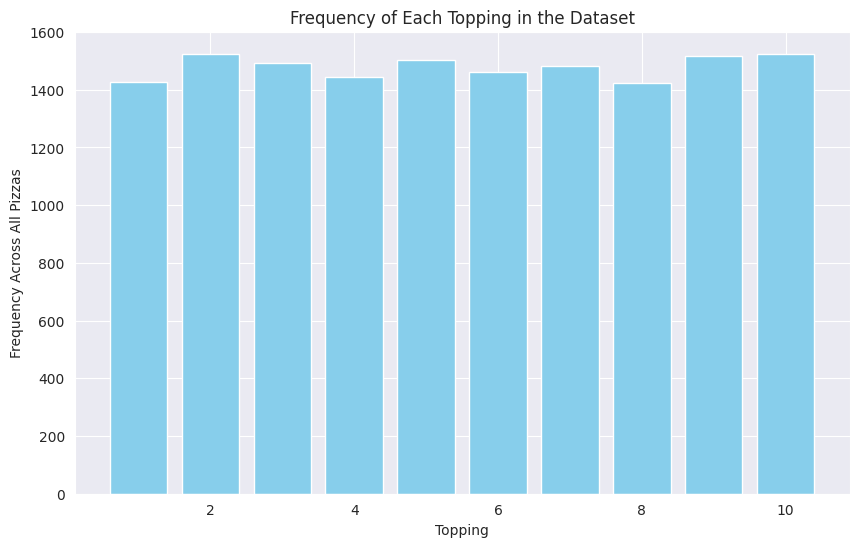

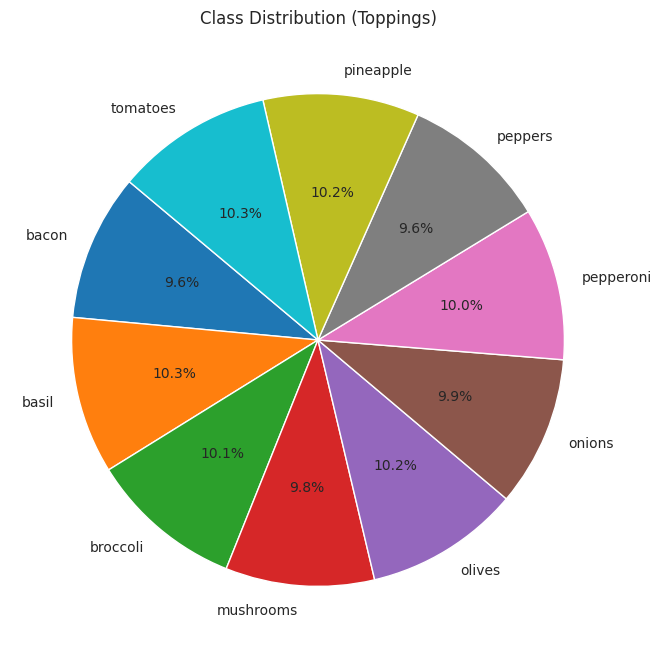

In [8]:
topping_frequency = np.sum(y_all, axis=0)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(np.arange(1, len(topping_frequency)+1), topping_frequency, color='skyblue', width=0.8)

# Labeling
plt.xlabel('Topping')
plt.ylabel('Frequency Across All Pizzas')
plt.title('Frequency of Each Topping in the Dataset')

# Display the plot
plt.show()

class_distribution = np.sum(y_all, axis=0)

# Plotting
plt.figure(figsize=(8, 8))
plt.pie(class_distribution, labels=topping_names, autopct='%1.1f%%', startangle=140)

# Labeling
plt.title('Class Distribution (Toppings)')

# Display the plot
plt.show()

Class Distribution in Train and Test Sets

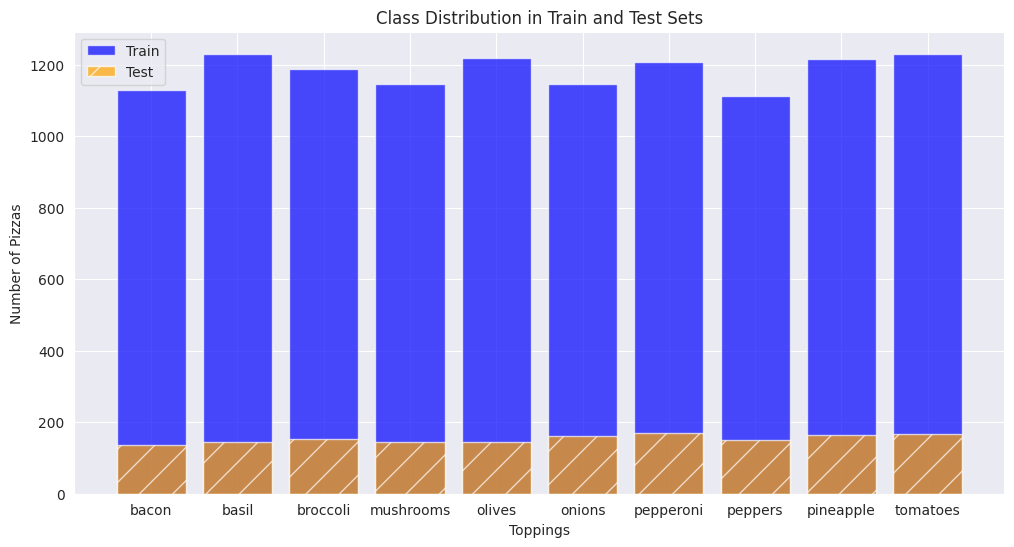

In [9]:
# Calculate class distribution
class_distribution_train = np.sum(y_train, axis=0)
class_distribution_test = np.sum(y_test, axis=0)

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(topping_names, class_distribution_train, color='blue', alpha=0.7, label='Train')
plt.bar(topping_names, class_distribution_test, color='orange', alpha=0.7, label='Test', hatch='/')

# Labeling
plt.xlabel('Toppings')
plt.ylabel('Number of Pizzas')
plt.title('Class Distribution in Train and Test Sets')
plt.legend()

# Display the bar chart
plt.show()

### Display one sample image

0046.png


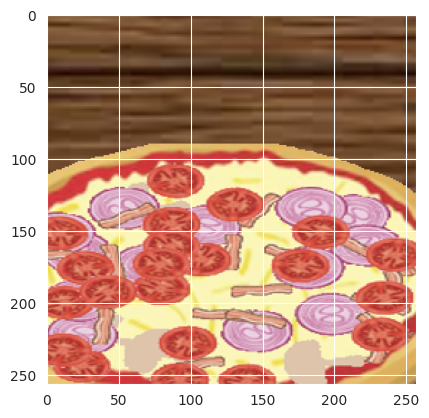

In [10]:
idx = 45

img_name = "{:04d}.png".format(idx+1)
print(img_name)

img_path = os.path.join(DATA_DIR, 'syntheticDataset/train/images')

img = Image.open(os.path.join(img_path, img_name))

plt.imshow(img)
plt.show()

### Store train images in memory

This should make learning faster.

# Helper functions

In [67]:
def load_image(image_path, image_size):
  """
  Load and resize an image from the given path
  """
  img = Image.open(image_path)
  img = img.resize((image_size, image_size))
  return np.array(img)


def store_image(image_idx, data_directory, filename, image_format="{:04d}.png", target_size=224):
  """
  Store images as numpy array data
  """
  processed_images = []
  # Numpy file exists
  if os.path.exists(os.path.join(data_directory, filename)):
    img_data_tensor = np.load(os.path.join(data_directory, filename))
    processed_images = img_data_tensor['img_data']
  else:
    for idx in tqdm(image_idx):
      img_name = image_format.format(idx + 1)
      img_path = os.path.join(data_directory, 'images', img_name)
      if os.path.exists(img_path):
        img_array = load_image(img_path, target_size)
        processed_images.append(img_array)
      else:
        print(f"Warning: Image file '{img_name}' not found.")

    np.savez_compressed(os.path.join(data_directory, filename), img_data=np.array(processed_images))

  return processed_images

In [64]:
train_data_path=os.path.join(DATA_DIR, 'syntheticDataset/train')

img_all = store_image(x_all, train_data_path, 'img_data_224.npz')

100%|██████████| 4971/4971 [1:09:08<00:00,  1.20it/s]


### Dataset class

In [13]:
class myDataset(Dataset):
    """Pizza dataset"""

    def __init__(self, x_idx, y, img_path='/content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images', img_data = None, transform=None):
      """
      Args:
      """
      self.x_idx = x_idx
      self.y = y
      self.img_path = img_path
      self.transform = transform
      self.img_data = img_data

    def __getitem__(self, idx):
      if isinstance(self.img_data,np.ndarray):
        x = Image.fromarray(self.img_data[idx,:,:,:])
      else:
        img_name = "{:04d}.png".format(idx+1)
        x = Image.open(os.path.join(self.img_path, img_name))
      y = self.y[idx,:]
      if self.transform:
          x = self.transform(x)
      y = np.int64(y)
      return x, y

    def __len__(self):
        return int(len(self.x_idx))


### Data loaders

In [14]:
batch_size = 25

input_size = 224

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.ColorJitter(brightness=32. / 255., saturation=0.5),
                                         transforms.Resize(input_size),
                                         transforms.ToTensor(),
                                     normalize])

val_transform = transforms.Compose([transforms.Resize(input_size),
                                    transforms.ToTensor(),
                                   normalize])

kwargs = {'num_workers': 2, 'pin_memory': True} if torch.cuda.is_available() else {}

train_data_path=img_path = os.path.join(DATA_DIR, 'syntheticDataset/train/images')

img_data_train = img_all[x_train,:,:,:]
train_set_raw = myDataset(x_train, y_train, img_path=train_data_path, img_data=img_data_train, transform = train_transform)
train_dataloader = DataLoader(train_set_raw, batch_size=batch_size, shuffle=True, **kwargs)

img_data_val = img_all[x_val,:,:,:]
val_set_raw = myDataset(x_val, y_val, img_path=train_data_path, img_data=img_data_val, transform = val_transform)
val_dataloader = DataLoader(val_set_raw, batch_size=batch_size, shuffle=False, **kwargs)

test_data_path=img_path = os.path.join(DATA_DIR, 'syntheticDataset/test/images')

test_set_raw = myDataset(x_test, y_test, img_path=test_data_path, transform = val_transform)
test_dataloader = DataLoader(test_set_raw, batch_size=batch_size, shuffle=False, **kwargs)


### Visualize data loader

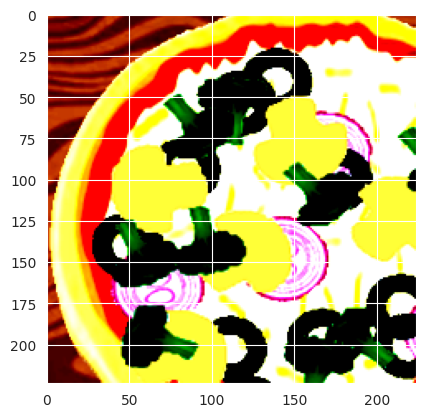

torch.Size([25, 3, 224, 224])


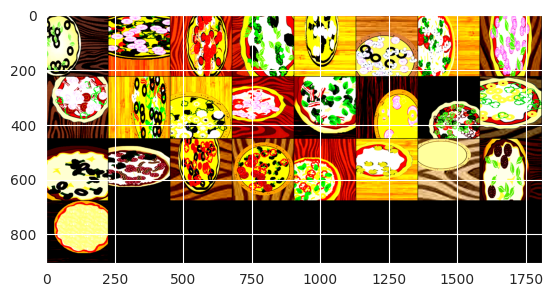

In [15]:
# Show dataset sample
x,y = test_set_raw[45]
#print(x,y)

plt.imshow(x.permute(1, 2, 0).numpy())
plt.show()

# Show batch of images
#it = iter(train_dataloader)
sample,labels = next(iter(train_dataloader))
print(sample.shape)

out = torchvision.utils.make_grid(sample)
plt.imshow(out.permute(1, 2, 0))


### Learning

There are several possibilities to solve the problem:

* Extract good features and apply a simple predictor. The problem is to find good features for the problem: you know what they can be and how to compute them, or you can rely on "generic" features like bag of visual words, histograms or deep features.

* Work on raw data and build the label predictor directly. This is typically an approach for deep learning.

Notice that the problem is **multi-label prediction**, not classification. Each image may be characterized by several labels.


### Simple network definition

An elementary convolutional network with input datasize of 32x32.

If you want to  use it, you will need to modify the dataloader.

In [16]:
# network class
class SimpleCNN(nn.Module):
    # Network requires 32x32 input images
    def __init__(self, nlabel=10):
        super(SimpleCNN, self).__init__()
        self.nlabel = nlabel

        # define here the convolutions and linear layers
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)

        # dynamically calculate the input size for the linear layer
        x = torch.randn(1, 3, 224, 224)
        self._conv_size(x)

        self.lin1 = nn.Linear(self.conv_out_size, 128)
        self.lin2 = nn.Linear(128, self.nlabel)

    def forward(self, x):
        # 32x32

        # define here the forward pass
        x1 = self.conv1(x)
        x1r = F.relu(x1)
        x1p = F.max_pool2d(x1r, 2)

        # 16x16
        x2 = self.conv2(x1p)
        x2r = F.relu(x2)
        x2p = F.max_pool2d(x2r, 2)

        # 8x8
        x3 = self.conv3(x2p)
        x3r = F.relu(x3)
        x3p = F.max_pool2d(x3r, 2)

        # 4x4
        y0 = x3p.view(x3p.size(0), -1)

        y1 = self.lin1(y0)
        y1r = F.relu(y1)
        y2 = self.lin2(y1r)

        return y2

    def _conv_size(self, x):
        # Helper function to calculate the output size of the last convolutional layer
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        self.conv_out_size = x.view(x.size(0), -1).size(1)


In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output

def train_model_multilabel(model, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=5):
    # Lists for saving accuracies and losses
    train_perf = []
    val_perf = []
    train_losses = []
    val_losses = []

    # Threshold for binary classification (if Sigmoid is not used in the last layer)
    threshold = 0.5
    total_step = len(valloader)

    # Iterate over epochs
    for epoch in range(num_epochs):
        print(f"Epoch ({epoch + 1}/{num_epochs})")

        # Set the model to training mode
        model.train()
        train_perf_for_epoch = np.zeros((1, nlabel))

        # Training loop
        losses = []
        for inputs, targets in tqdm(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Convert to float32 if needed
            outputs = outputs.to(torch.float32)
            targets = targets.to(torch.float32)

            # Calculate loss
            loss = criterion(outputs, targets)
            losses.append(loss.item())

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Calculate training accuracy
            outputs_np = outputs.cpu().detach().numpy()
            targets_np = targets.cpu().detach().numpy()
            predictions = (outputs_np > threshold)
            train_perf_for_epoch = train_perf_for_epoch + (targets_np == predictions).sum(axis=0)

        # Save training performance and losses
        train_perf.append(train_perf_for_epoch[0] / len(trainloader.dataset))
        train_losses.append(round(losses[-1], 4))

        # Display learning rate
        for param_group in optimizer.param_groups:
            print(f"Learning rate: {round(param_group['lr'], 6)}")

        print(f"Training performance mean: {round(train_perf[-1].mean(), 4)}")

        # Adjust learning rate if scheduler is provided
        if scheduler is not None:
            scheduler.step()

        # Validation loop
        val_perf_for_epoch = np.zeros((1, nlabel))

        # Set the model to evaluation mode
        model.eval()
        with torch.no_grad():
            losses = []
            for inputs, targets in tqdm(valloader):
                inputs, targets = inputs.to(device), targets.to(device)

                # Forward pass during validation
                outputs = model(inputs)

                # Convert to float32 if needed
                outputs = outputs.to(torch.float32)
                targets = targets.to(torch.float32)

                # Calculate validation loss
                loss_val = criterion(outputs, targets)
                losses.append(loss_val.item())

                # Calculate validation accuracy
                outputs_np = outputs.cpu().detach().numpy()
                targets_np = targets.cpu().detach().numpy()
                predictions = (outputs_np > threshold)
                val_perf_for_epoch = val_perf_for_epoch + (targets_np == predictions).sum(axis=0)

        # Save validation performance and losses
        val_perf.append(val_perf_for_epoch[0] / len(valloader.dataset))
        print(f"Validation loss: {round(losses[-1], 4)}")
        val_losses.append(round(losses[-1], 4))
        print(f"Validation performance mean: {round(val_perf[-1].mean(), 4)}\n")

    return model, train_perf, val_perf, train_losses, val_losses


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


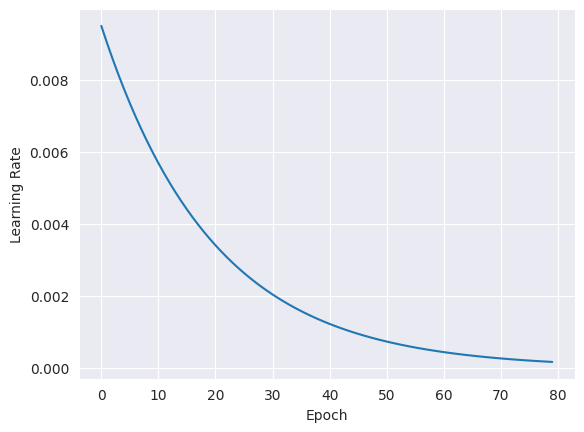

In [18]:
nlabel = y_all.shape[1]

network = SimpleCNN(nlabel = nlabel)

# Name of the network
tag = "simpleCNN"

# Hyperparamenets
max_learning_rate = 0.01
max_epoch = 20
# batch_size = 64

# Data loaders
trainloader = train_dataloader
valloader = val_dataloader

# Read the last learned network (if stored)
# if (os.path.exists(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))):
#     print('Resume from last learning step')
#     network = torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))

# Transfer network to GPU
network.to(device)

# Define learning components (to be used in the learning function)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=max_learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Visualize learning rate change during training

# List to store learning rates during training
learning_rates_history = []
num_epochs = 80

for epoch in range(num_epochs):
    scheduler.step()

    # Store learning rate for visualization
    learning_rates_history.append(optimizer.param_groups[0]["lr"])

plt.plot(range(num_epochs), learning_rates_history)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

Learning

Training the model:
Epoch (1/20)


100%|██████████| 160/160 [00:17<00:00,  8.99it/s]


Learning rate: 0.000165
Training performance mean: 0.7148


100%|██████████| 40/40 [00:01<00:00, 22.98it/s]


Validation loss: 0.5166
Validation performance mean: 0.74

Epoch (2/20)


100%|██████████| 160/160 [00:13<00:00, 11.88it/s]


Learning rate: 0.000157
Training performance mean: 0.749


100%|██████████| 40/40 [00:01<00:00, 23.28it/s]


Validation loss: 0.476
Validation performance mean: 0.757

Epoch (3/20)


100%|██████████| 160/160 [00:13<00:00, 11.96it/s]


Learning rate: 0.000149
Training performance mean: 0.7645


100%|██████████| 40/40 [00:01<00:00, 23.11it/s]


Validation loss: 0.4713
Validation performance mean: 0.7658

Epoch (4/20)


100%|██████████| 160/160 [00:13<00:00, 12.13it/s]


Learning rate: 0.000142
Training performance mean: 0.7757


100%|██████████| 40/40 [00:01<00:00, 24.24it/s]


Validation loss: 0.4628
Validation performance mean: 0.7757

Epoch (5/20)


100%|██████████| 160/160 [00:13<00:00, 12.20it/s]


Learning rate: 0.000135
Training performance mean: 0.7853


100%|██████████| 40/40 [00:01<00:00, 23.48it/s]


Validation loss: 0.4664
Validation performance mean: 0.781

Epoch (6/20)


100%|██████████| 160/160 [00:13<00:00, 12.19it/s]


Learning rate: 0.000128
Training performance mean: 0.7914


100%|██████████| 40/40 [00:02<00:00, 16.93it/s]


Validation loss: 0.4466
Validation performance mean: 0.7876

Epoch (7/20)


100%|██████████| 160/160 [00:12<00:00, 12.79it/s]


Learning rate: 0.000121
Training performance mean: 0.7991


100%|██████████| 40/40 [00:02<00:00, 14.99it/s]


Validation loss: 0.4476
Validation performance mean: 0.791

Epoch (8/20)


100%|██████████| 160/160 [00:13<00:00, 11.47it/s]


Learning rate: 0.000115
Training performance mean: 0.8057


100%|██████████| 40/40 [00:01<00:00, 22.45it/s]


Validation loss: 0.4224
Validation performance mean: 0.797

Epoch (9/20)


100%|██████████| 160/160 [00:14<00:00, 10.85it/s]


Learning rate: 0.00011
Training performance mean: 0.8141


100%|██████████| 40/40 [00:01<00:00, 24.16it/s]


Validation loss: 0.4165
Validation performance mean: 0.8034

Epoch (10/20)


100%|██████████| 160/160 [00:13<00:00, 12.12it/s]


Learning rate: 0.000104
Training performance mean: 0.818


100%|██████████| 40/40 [00:01<00:00, 23.86it/s]


Validation loss: 0.4172
Validation performance mean: 0.8058

Epoch (11/20)


100%|██████████| 160/160 [00:13<00:00, 12.21it/s]


Learning rate: 9.9e-05
Training performance mean: 0.8235


100%|██████████| 40/40 [00:01<00:00, 23.72it/s]


Validation loss: 0.4036
Validation performance mean: 0.8137

Epoch (12/20)


100%|██████████| 160/160 [00:13<00:00, 11.96it/s]


Learning rate: 9.4e-05
Training performance mean: 0.8278


100%|██████████| 40/40 [00:01<00:00, 24.10it/s]


Validation loss: 0.4012
Validation performance mean: 0.8118

Epoch (13/20)


100%|██████████| 160/160 [00:13<00:00, 12.21it/s]


Learning rate: 8.9e-05
Training performance mean: 0.8317


100%|██████████| 40/40 [00:01<00:00, 24.36it/s]


Validation loss: 0.4021
Validation performance mean: 0.8211

Epoch (14/20)


100%|██████████| 160/160 [00:13<00:00, 12.29it/s]


Learning rate: 8.5e-05
Training performance mean: 0.8373


100%|██████████| 40/40 [00:01<00:00, 25.00it/s]


Validation loss: 0.4145
Validation performance mean: 0.8198

Epoch (15/20)


100%|██████████| 160/160 [00:13<00:00, 11.76it/s]


Learning rate: 8.1e-05
Training performance mean: 0.8401


100%|██████████| 40/40 [00:02<00:00, 16.63it/s]


Validation loss: 0.4063
Validation performance mean: 0.8228

Epoch (16/20)


100%|██████████| 160/160 [00:12<00:00, 12.62it/s]


Learning rate: 7.7e-05
Training performance mean: 0.8454


100%|██████████| 40/40 [00:02<00:00, 15.20it/s]


Validation loss: 0.4283
Validation performance mean: 0.8124

Epoch (17/20)


100%|██████████| 160/160 [00:17<00:00,  9.01it/s]


Learning rate: 7.3e-05
Training performance mean: 0.846


100%|██████████| 40/40 [00:01<00:00, 24.75it/s]


Validation loss: 0.3824
Validation performance mean: 0.8257

Epoch (18/20)


100%|██████████| 160/160 [00:13<00:00, 11.90it/s]


Learning rate: 6.9e-05
Training performance mean: 0.8493


100%|██████████| 40/40 [00:01<00:00, 23.97it/s]


Validation loss: 0.4001
Validation performance mean: 0.8254

Epoch (19/20)


100%|██████████| 160/160 [00:13<00:00, 12.12it/s]


Learning rate: 6.6e-05
Training performance mean: 0.8521


100%|██████████| 40/40 [00:01<00:00, 23.88it/s]


Validation loss: 0.3862
Validation performance mean: 0.8272

Epoch (20/20)


100%|██████████| 160/160 [00:13<00:00, 11.80it/s]


Learning rate: 6.2e-05
Training performance mean: 0.8569


100%|██████████| 40/40 [00:01<00:00, 23.80it/s]


Validation loss: 0.3892
Validation performance mean: 0.8281



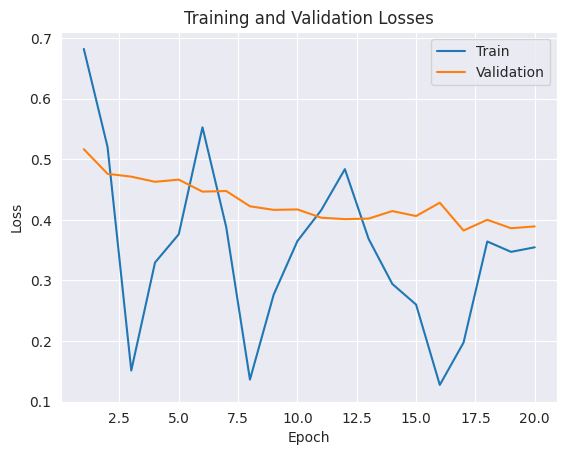


Train accuracies: [array([0.7193159 , 0.69039235, 0.70120724, 0.77464789, 0.69668008,
       0.71202213, 0.71830986, 0.71981891, 0.69567404, 0.72032193]), array([0.74597586, 0.68938632, 0.70472837, 0.83249497, 0.71076459,
       0.71202213, 0.79703219, 0.72157948, 0.70699195, 0.8694668 ]), array([0.7555332 , 0.68988934, 0.72157948, 0.85261569, 0.72308853,
       0.71151911, 0.82545272, 0.72208249, 0.72359155, 0.92002012]), array([0.76257545, 0.69089537, 0.73365191, 0.87650905, 0.72962777,
       0.71227364, 0.84280684, 0.72409457, 0.73717304, 0.94768612]), array([0.77741449, 0.69064386, 0.74346076, 0.88405433, 0.74371227,
       0.71277666, 0.85613682, 0.73138833, 0.75251509, 0.9610161 ]), array([0.78495976, 0.69517103, 0.75176056, 0.89562374, 0.75075453,
       0.71554326, 0.85940644, 0.73138833, 0.76131791, 0.96856137]), array([0.79275654, 0.69768612, 0.76307847, 0.90618712, 0.76685111,
       0.71705231, 0.86770624, 0.74220322, 0.76911469, 0.96881288]), array([0.79703219, 0.6981891

In [19]:
print("Training the model:")

# Train the model
learned_model, train_accuracy, test_accuracy, train_losses, val_losses = train_model_multilabel(
    network, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=max_epoch
)

# Save the trained model
torch.save(learned_model, os.path.join(img_path, f'network_{tag}.pth'))
network = learned_model

# Plotting the training and validation losses
plt.plot(range(1, max_epoch + 1), train_losses, label='Train')
plt.plot(range(1, max_epoch + 1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

print("\nTrain accuracies: {}".format(train_accuracy))
print("Test accuracies: {}".format(test_accuracy))
print("Train losses: {}".format(train_losses))

In [42]:
def calculate_performance(targets, predictions):
    """
    Calculate performance metrics based on targets and predictions
    """
    # Convert lists to numpy arrays
    targets_np = np.array(targets)
    predictions_np = np.array(predictions)

    # Calculate accuracy per label
    accuracy_per_label = (targets_np == predictions_np).mean(axis=0)

    # Calculate mean accuracy
    mean_accuracy = accuracy_per_label.mean()

    # Store performance metrics in a dictionary
    performance = {
        'accuracy_per_label': accuracy_per_label,
        'mean_accuracy': mean_accuracy
    }

    return performance

def generate_classification_report(targets, predictions, labels=None):
    """
    Generate a classification report based on targets and predictions
    """
    # Convert lists to numpy arrays
    targets_np = np.array(targets)
    predictions_np = np.array(predictions)

    # Generate classification report
    report = classification_report(targets_np, predictions_np, target_names=labels)

    return report


def evaluate_model(network, dataloader, device=torch.device('cpu')):
    """
    Evaluate the performance of a model
    """
    # Set the model to evaluation mode
    network.eval()

    # Create empty arrays to store predictions and targets
    all_predictions = []
    all_targets = []

    # Tell not to reserve memory space for gradients (faster inference)
    threshold = 0.5
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, ncols=80):
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Compute outputs
            outputs = network(inputs)
            predictions = torch.sigmoid(outputs) > threshold

            # Convert tensors to numpy arrays
            predictions_np = predictions.cpu().detach().numpy()
            targets_np = targets.cpu().detach().numpy()

            # Concatenate predictions and targets
            all_predictions.extend(predictions_np)
            all_targets.extend(targets_np)

    # Calculate performance metrics
    performance = calculate_performance(all_targets, all_predictions)

    # Generate classification report
    metrics_report = generate_classification_report(all_targets, all_predictions)

    return performance, metrics_report


def print_performance(performance, labels=None):
    """
    Print performance metrics
    """
    print("\nPerformance:")
    accuracy_per_label = performance['accuracy_per_label']
    mean_accuracy = performance['mean_accuracy']
    print(f"Mean accuracy: {mean_accuracy:.2%}")

    print("Accuracy per label:")
    if labels:
        for label, accuracy in zip(labels, accuracy_per_label):
            print(f"{label}: {accuracy:.2%}")
    else:
        for i, accuracy in enumerate(accuracy_per_label):
            print(f"Label {i + 1}: {accuracy:.2%}")



In [38]:
def get_random_batch(test_dataloader):
    """
    Get a random batch from the test dataloader
    """
    batch_idx = random.randint(0, len(test_dataloader) - 1)
    for i, data in enumerate(test_dataloader):
        if i == batch_idx:
            inputs, targets = data
            return inputs, targets


def extract_labels_from_vector(vector, labels_name):
    """
    Extract the labels present in the image based on the binary vector
    """
    labels = [labels_name[i] for i, val in enumerate(vector) if val]
    return labels


def visualize_results(inputs, outputs, targets, labels_name):
    """
    Visualize the results of predictions on a batch
    """
    batch_size = inputs.size(0)

    # Move tensors to CPU if they are on CUDA device
    inputs = inputs.cpu()
    outputs = outputs.cpu()
    targets = targets.cpu()

    for idx in range(batch_size):
        predicted_labels = extract_labels_from_vector(outputs[idx] > 0, labels_name)
        true_labels = extract_labels_from_vector(targets[idx] == 1, labels_name)
        print("Batch: ", idx)
        print("Predicted labels by the model:", ', '.join(predicted_labels))
        print("True labels: ", ', '.join(true_labels))
        print("Image: ")

        # Convert tensor to numpy array for visualization
        image = inputs[idx].permute(1, 2, 0).numpy()
        plt.imshow(image)
        plt.show()


def test_random_batch(network, labels_name, test_dataloader, device=torch.device('cpu')):
    """
    Show results on a random batch from the test dataset
    """
    # Set the model to evaluation mode
    network.eval()
    print("Set the model to evaluation mode")

    # Get a random batch from the test dataloader
    inputs, targets = get_random_batch(test_dataloader)
    print("Got a random batch from the test dataloader")

    # Move inputs to the device
    inputs = inputs.to(device)
    print("Moved inputs to the device")

    # Perform inference
    with torch.no_grad():
        outputs = network(inputs)
        print("Performed inference")

    # Move outputs and targets to CPU before converting to numpy
    outputs = outputs.cpu()
    targets = targets.cpu()
    print("Moved outputs and targets to CPU before converting to numpy")

    # Visualize the results
    visualize_results(inputs, outputs, targets, labels_name)


Set the model to evaluation mode


Got a random batch from the test dataloader
Moved inputs to the device
Performed inference
Moved outputs and targets to CPU before converting to numpy
Batch:  0
Predicted labels by the model: olives, pineapple, tomatoes
True labels:  olives, peppers, pineapple, tomatoes
Image: 


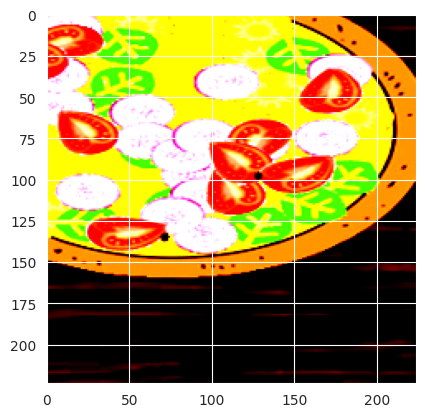

Batch:  1
Predicted labels by the model: pepperoni, tomatoes
True labels:  broccoli, pepperoni, tomatoes
Image: 


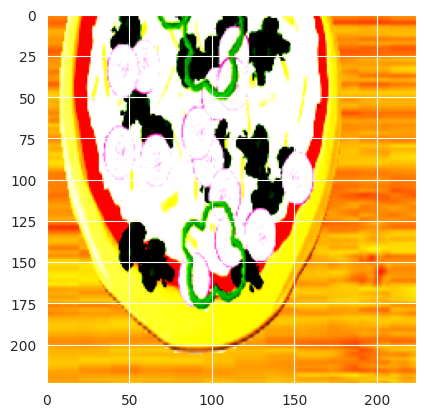

Batch:  2
Predicted labels by the model: peppers, pineapple
True labels:  onions, peppers, pineapple
Image: 


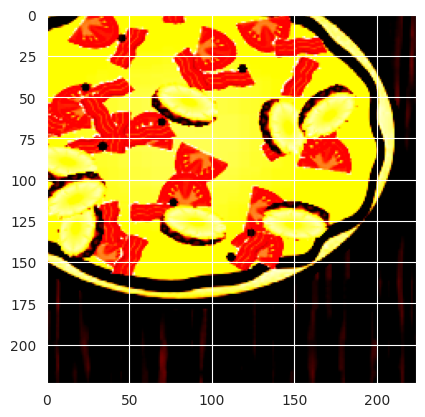

Batch:  3
Predicted labels by the model: pepperoni, pineapple
True labels:  bacon, pepperoni, pineapple
Image: 


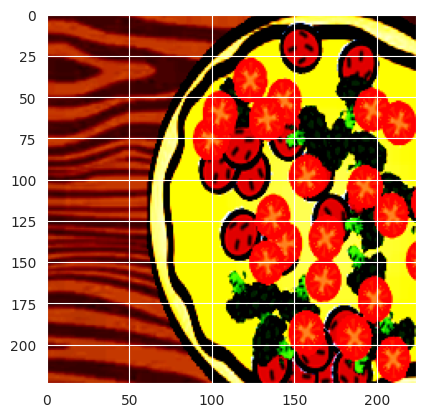

Batch:  4
Predicted labels by the model: peppers
True labels:  bacon, olives, peppers
Image: 


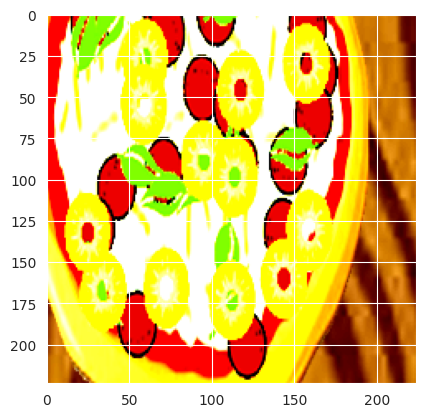

Batch:  5
Predicted labels by the model: peppers
True labels:  basil
Image: 


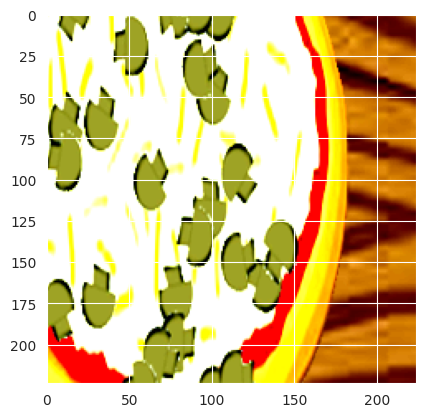

Batch:  6
Predicted labels by the model: peppers, tomatoes
True labels:  onions, peppers, tomatoes
Image: 


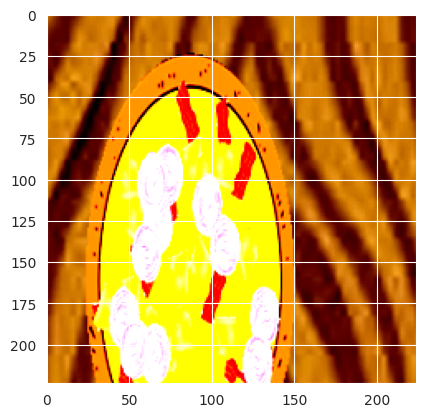

Batch:  7
Predicted labels by the model: pineapple
True labels:  peppers, pineapple
Image: 


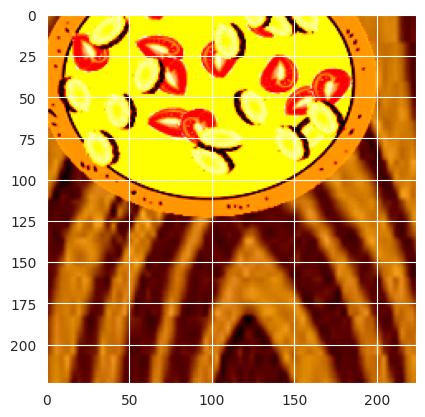

Batch:  8
Predicted labels by the model: broccoli, pepperoni
True labels:  broccoli, onions, pepperoni
Image: 


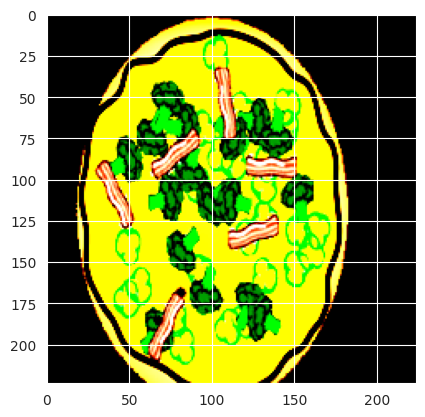

Batch:  9
Predicted labels by the model: bacon, olives, tomatoes
True labels:  basil, broccoli, olives, pineapple, tomatoes
Image: 


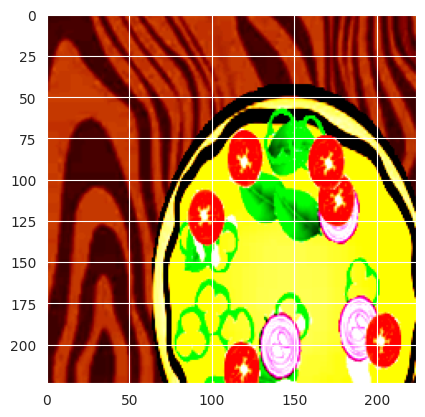

Batch:  10
Predicted labels by the model: onions, tomatoes
True labels:  bacon, onions, tomatoes
Image: 


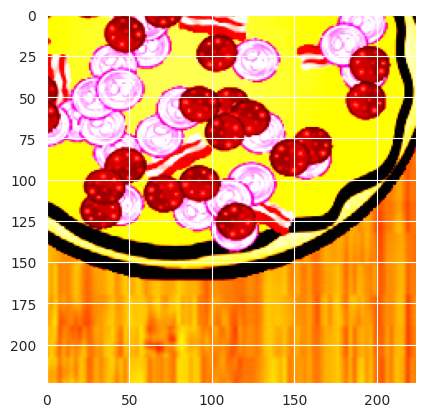

Batch:  11
Predicted labels by the model: mushrooms
True labels:  mushrooms
Image: 


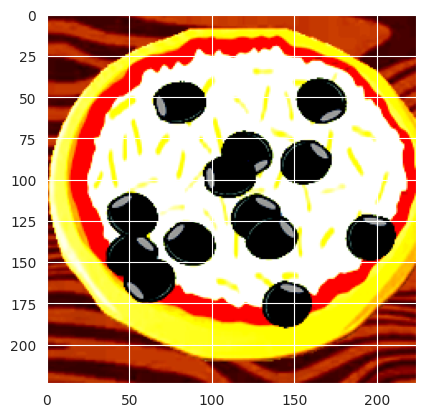

Batch:  12
Predicted labels by the model: bacon, basil, olives, pineapple, tomatoes
True labels:  bacon, basil, broccoli, olives, onions, tomatoes
Image: 


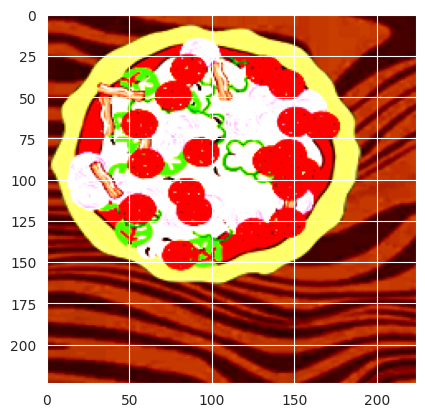

Batch:  13
Predicted labels by the model: mushrooms, pepperoni, peppers
True labels:  mushrooms, pepperoni, peppers
Image: 


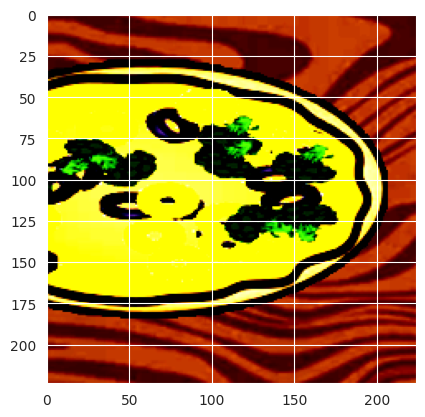

Batch:  14
Predicted labels by the model: mushrooms
True labels:  basil, mushrooms
Image: 


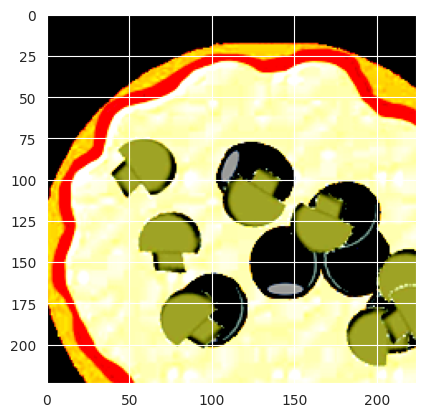

Batch:  15
Predicted labels by the model: onions, pineapple, tomatoes
True labels:  basil, pineapple, tomatoes
Image: 


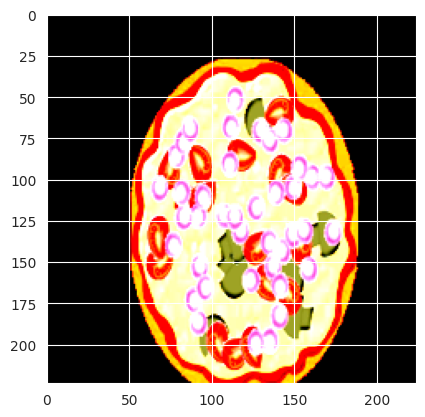

Batch:  16
Predicted labels by the model: pineapple, tomatoes
True labels:  bacon, olives, tomatoes
Image: 


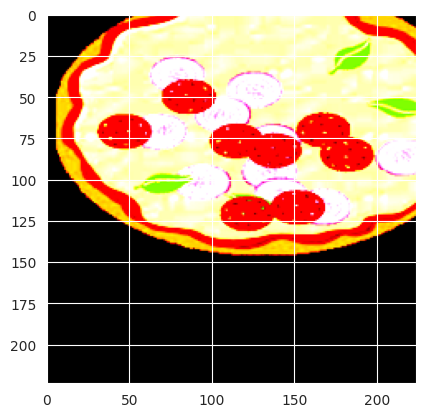

Batch:  17
Predicted labels by the model: broccoli, pepperoni, pineapple
True labels:  olives, pepperoni, pineapple
Image: 


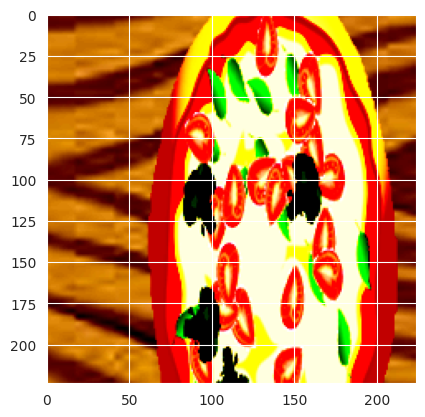

Batch:  18
Predicted labels by the model: olives, pepperoni, peppers
True labels:  olives, onions, pepperoni, peppers
Image: 


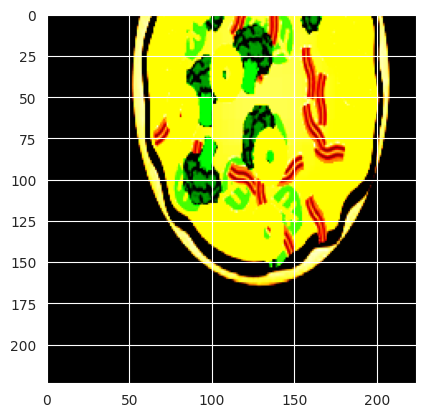

Batch:  19
Predicted labels by the model: basil, tomatoes
True labels:  basil, tomatoes
Image: 


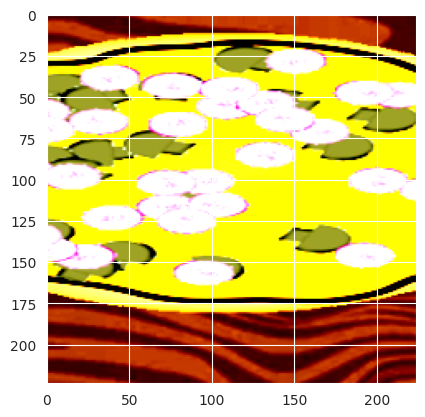

Batch:  20
Predicted labels by the model: basil, olives, pepperoni, tomatoes
True labels:  broccoli, pepperoni, tomatoes
Image: 


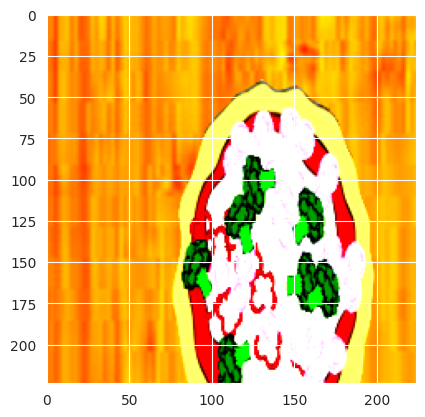

Batch:  21
Predicted labels by the model: mushrooms
True labels:  mushrooms, onions
Image: 


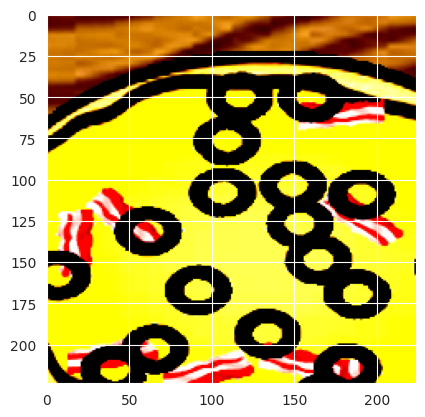

Batch:  22
Predicted labels by the model: onions, pineapple, tomatoes
True labels:  basil, broccoli, peppers, pineapple, tomatoes
Image: 


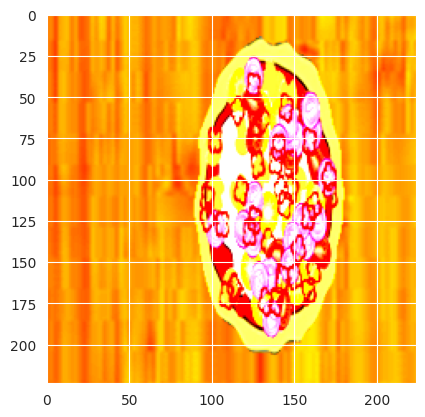

Batch:  23
Predicted labels by the model: bacon, broccoli
True labels:  bacon, broccoli, onions
Image: 


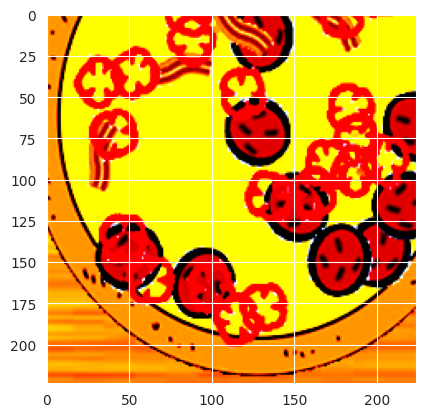

Batch:  24
Predicted labels by the model: onions, pepperoni
True labels:  broccoli, olives
Image: 


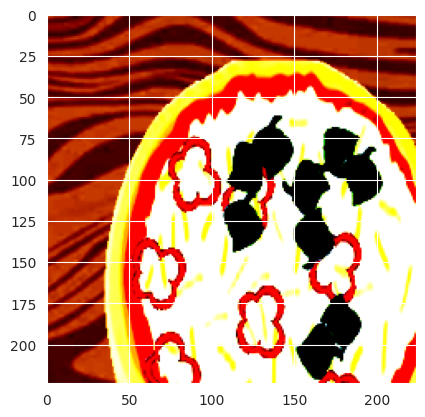

In [39]:
test_random_batch(network=network, labels_name=topping_names, test_dataloader=test_dataloader, device=device)

In [43]:
performance, metrics_report = evaluate_model(network = network, dataloader=test_dataloader, device=device)
print_performance(performance, topping_names)
print("\nMetrics Report: \n", metrics_report)

100%|███████████████████████████████████████████| 20/20 [00:03<00:00,  6.44it/s]


Performance:
Mean accuracy: 82.52%
Accuracy per label:
bacon: 81.29%
basil: 75.65%
broccoli: 78.47%
mushrooms: 93.16%
olives: 85.11%
onions: 66.00%
pepperoni: 86.92%
peppers: 77.67%
pineapple: 82.29%
tomatoes: 98.59%

Metrics Report: 
               precision    recall  f1-score   support

           0       0.74      0.50      0.59       137
           1       0.65      0.38      0.48       146
           2       0.73      0.47      0.57       152
           3       1.00      0.77      0.87       146
           4       0.81      0.63      0.71       145
           5       0.46      0.26      0.33       162
           6       0.86      0.73      0.79       169
           7       0.80      0.34      0.48       149
           8       0.81      0.61      0.69       164
           9       0.99      0.96      0.98       168

   micro avg       0.81      0.57      0.67      1538
   macro avg       0.79      0.57      0.65      1538
weighted avg       0.79      0.57      0.65      1538
 samp


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# EfficientNet

In [55]:
def load_image_list(train_label_path, test_label_path=None, max_image=None, test_size=0.3, val_size=0.2):
    """
    Load image data from label files and split them into train, validation, and test sets
    """

    # Load labels from files
    y_all_train = np.loadtxt(os.path.join(DATA_DIR, train_label_path))
    if max_image is not None:
        y_all_train = y_all_train[:min(len(y_all_train), max_image)]

    # Generate indices for images
    x_all_train = np.arange(y_all_train.shape[0])

    # Split data into train, val, and test sets
    if test_label_path is not None:
        # Load test labels
        y_all_test = np.loadtxt(os.path.join(DATA_DIR, test_label_path))
        x_all_test = np.arange(y_all_test.shape[0])

        # Split train data into train and validation sets
        x_train, x_val, y_train, y_val = train_test_split(x_all_train, y_all_train, test_size=val_size, random_state=123)

        # Use test data directly
        x_test, y_test = x_all_test, y_all_test
    else:
        # Split data into train, validation, and test sets
        x_train, x_test, y_train, y_test = train_test_split(x_all_train, y_all_train, test_size=test_size, random_state=123)
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size/(1-test_size), random_state=123)

    # Print info about the data
    ntrain = x_train.shape[0]
    ndim = y_train.shape[1]

    print("The data is of dimension {:d}".format(ndim))
    print("The number of training data is {:d}".format(ntrain))
    print("The number of test data is {:d}".format(x_test.shape[0]))

    return x_train, y_train, x_val, y_val, x_test, y_test

In [65]:
def create_dataloader(x_data, y_data, img_data, data_path, datasetClass, batch_size, transform=None, shuffle=False):
    kwargs = {'num_workers': 2, 'pin_memory': True} if torch.cuda.is_available() else {}

    if img_data is not None:
        img_data = img_data[x_data, :, :, :]

    raw_dataset = datasetClass(x_data, y_data, img_path=data_path, img_data=img_data, transform = transform)
    dataloader = DataLoader(raw_dataset, batch_size=batch_size, shuffle=shuffle, **kwargs)

    return dataloader

In [68]:
# Check the shape of img_data
print("Shape of img_data:", img_data.shape)

# Creation of the dataloader for the model training
train_dataloader = create_dataloader(x_train, y_train, img_data, train_data_path, myDataset, batch_size, transform=train_transform, shuffle=True)


Shape of img_data: (4971, 224, 224, 3)


In [69]:
batch_size = 25
input_size = 224

x_train, y_train, x_val, y_val, x_test, y_test = load_image_list('syntheticDataset/train/trainLabels.txt',
                                                                'syntheticDataset/test/testLabels.txt',
                                                                 val_size=0.1)
img_all = store_image(np.concatenate((x_train, x_val)), train_data_path, 'img_data_224.npz')

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create the list of transformations that will be computed on the training pictures to make the model more robust
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.ColorJitter(brightness=32. / 255., saturation=0.5),
                                         transforms.Resize((input_size, input_size)),
                                         transforms.ToTensor(),
                                     normalize])

# Create the list of transformations necessary for the data to fit the model
val_transform = transforms.Compose([transforms.Resize((input_size, input_size)),
                                    transforms.ToTensor(),
                                   normalize])

# Conversion of img_all to a ndarray
img_data=np.array(img_all)


# Creation of the dataloader for the model training
# train_data_path=img_path = os.path.join(DATA_DIR, 'syntheticDataset/train/images')
train_dataloader = create_dataloader(x_train, y_train, img_all, train_data_path, myDataset, batch_size, transform=train_transform, shuffle=True)


# Creation of the dataloader for the model validation
val_dataloader = create_dataloader(x_val, y_val, img_all, train_data_path, myDataset, batch_size, transform=val_transform, shuffle=False)


# Creation of the dataloader for the model test
test_data_path=img_path = os.path.join(DATA_DIR, 'syntheticDataset/test/images')
test_dataloader = create_dataloader(x_test, y_test, None, test_data_path, myDataset, batch_size, transform=val_transform, shuffle=False)


The data is of dimension 10
The number of training data is 4473
The number of test data is 497


torch.Size([25, 3, 224, 224])


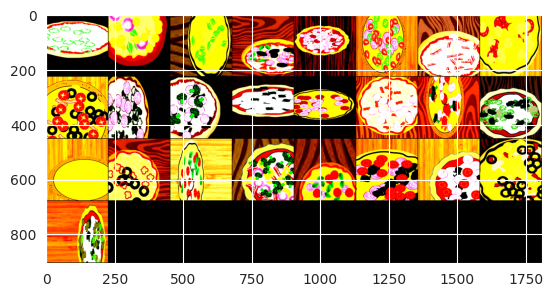

In [70]:
sample,labels = next(iter(train_dataloader))
print(sample.shape)

out = torchvision.utils.make_grid(sample)
plt.imshow(out.permute(1, 2, 0))

In [71]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

tag = "efficientNet"

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

WeightsEnum.get_state_dict = get_state_dict

efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
efficientnet_b0(weights="DEFAULT")

network = torchvision.models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
num_ftrs = network.classifier[1].in_features
network.classifier[1]= nn.Linear(num_ftrs, nlabel) # layer to match to the number of labels

if os.path.exists("networks/network_synthetic_" + tag + ".pth"):
    print("Loading pretrained network")
    network = torch.load("networks/network_synthetic_" + tag + ".pth")

# Transfer network to GPU
network.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 27.9MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Epoch (1/20)


100%|██████████| 179/179 [00:24<00:00,  7.16it/s]


Learning rate: 1e-05
Training performance mean: 0.7045


100%|██████████| 20/20 [00:01<00:00, 17.46it/s]


Validation loss: 6.5133
Validation performance mean: 0.6978

Epoch (2/20)


100%|██████████| 179/179 [00:25<00:00,  7.06it/s]


Learning rate: 1e-05
Training performance mean: 0.7045


100%|██████████| 20/20 [00:01<00:00, 17.45it/s]


Validation loss: 6.5173
Validation performance mean: 0.698

Epoch (3/20)


100%|██████████| 179/179 [00:26<00:00,  6.83it/s]


Learning rate: 1e-05
Training performance mean: 0.7049


100%|██████████| 20/20 [00:01<00:00, 17.14it/s]


Validation loss: 6.51
Validation performance mean: 0.6986

Epoch (4/20)


100%|██████████| 179/179 [00:24<00:00,  7.23it/s]


Learning rate: 1e-05
Training performance mean: 0.7057


100%|██████████| 20/20 [00:01<00:00, 18.01it/s]


Validation loss: 6.5221
Validation performance mean: 0.6964

Epoch (5/20)


100%|██████████| 179/179 [00:24<00:00,  7.17it/s]


Learning rate: 1e-05
Training performance mean: 0.7071


100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


Validation loss: 6.5248
Validation performance mean: 0.6964

Epoch (6/20)


100%|██████████| 179/179 [00:27<00:00,  6.44it/s]


Learning rate: 1e-05
Training performance mean: 0.7051


100%|██████████| 20/20 [00:01<00:00, 17.45it/s]


Validation loss: 6.5096
Validation performance mean: 0.6958

Epoch (7/20)


100%|██████████| 179/179 [00:25<00:00,  6.99it/s]


Learning rate: 1e-05
Training performance mean: 0.7065


100%|██████████| 20/20 [00:01<00:00, 17.38it/s]


Validation loss: 6.5245
Validation performance mean: 0.6956

Epoch (8/20)


100%|██████████| 179/179 [00:26<00:00,  6.76it/s]


Learning rate: 1e-05
Training performance mean: 0.7078


100%|██████████| 20/20 [00:01<00:00, 17.59it/s]


Validation loss: 6.525
Validation performance mean: 0.6934

Epoch (9/20)


100%|██████████| 179/179 [00:24<00:00,  7.36it/s]


Learning rate: 1e-05
Training performance mean: 0.7083


100%|██████████| 20/20 [00:01<00:00, 11.74it/s]


Validation loss: 6.5233
Validation performance mean: 0.6944

Epoch (10/20)


100%|██████████| 179/179 [00:24<00:00,  7.37it/s]


Learning rate: 1e-05
Training performance mean: 0.7076


100%|██████████| 20/20 [00:01<00:00, 11.09it/s]


Validation loss: 6.5407
Validation performance mean: 0.6948

Epoch (11/20)


100%|██████████| 179/179 [00:27<00:00,  6.60it/s]


Learning rate: 1e-05
Training performance mean: 0.7087


100%|██████████| 20/20 [00:01<00:00, 16.67it/s]


Validation loss: 6.5385
Validation performance mean: 0.6942

Epoch (12/20)


100%|██████████| 179/179 [00:25<00:00,  7.13it/s]


Learning rate: 1e-05
Training performance mean: 0.7105


100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Validation loss: 6.5329
Validation performance mean: 0.6932

Epoch (13/20)


100%|██████████| 179/179 [00:25<00:00,  7.00it/s]


Learning rate: 1e-05
Training performance mean: 0.7118


100%|██████████| 20/20 [00:01<00:00, 11.76it/s]


Validation loss: 6.5486
Validation performance mean: 0.691

Epoch (14/20)


100%|██████████| 179/179 [00:26<00:00,  6.75it/s]


Learning rate: 1e-05
Training performance mean: 0.7107


100%|██████████| 20/20 [00:01<00:00, 17.12it/s]


Validation loss: 6.554
Validation performance mean: 0.6902

Epoch (15/20)


100%|██████████| 179/179 [00:25<00:00,  7.07it/s]


Learning rate: 1e-05
Training performance mean: 0.7136


100%|██████████| 20/20 [00:01<00:00, 16.82it/s]


Validation loss: 6.5432
Validation performance mean: 0.6912

Epoch (16/20)


100%|██████████| 179/179 [00:26<00:00,  6.85it/s]


Learning rate: 1e-05
Training performance mean: 0.7124


100%|██████████| 20/20 [00:01<00:00, 17.00it/s]


Validation loss: 6.5601
Validation performance mean: 0.6906

Epoch (17/20)


100%|██████████| 179/179 [00:26<00:00,  6.65it/s]


Learning rate: 1e-05
Training performance mean: 0.7135


100%|██████████| 20/20 [00:01<00:00, 14.62it/s]


Validation loss: 6.5873
Validation performance mean: 0.6898

Epoch (18/20)


100%|██████████| 179/179 [00:25<00:00,  6.90it/s]


Learning rate: 1e-05
Training performance mean: 0.7156


100%|██████████| 20/20 [00:01<00:00, 17.55it/s]


Validation loss: 6.5891
Validation performance mean: 0.6888

Epoch (19/20)


100%|██████████| 179/179 [00:26<00:00,  6.87it/s]


Learning rate: 1e-05
Training performance mean: 0.7162


100%|██████████| 20/20 [00:01<00:00, 11.62it/s]


Validation loss: 6.5809
Validation performance mean: 0.6896

Epoch (20/20)


100%|██████████| 179/179 [00:26<00:00,  6.79it/s]


Learning rate: 1e-05
Training performance mean: 0.7167


100%|██████████| 20/20 [00:01<00:00, 17.40it/s]


Validation loss: 6.5932
Validation performance mean: 0.6884



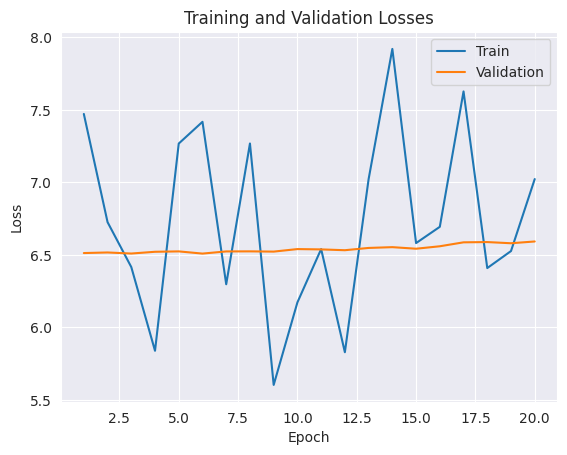


Train accuracies: [array([0.71786273, 0.69550637, 0.70154259, 0.70981444, 0.6959535 ,
       0.71048513, 0.70422535, 0.71763917, 0.69774201, 0.69438855]), array([0.71339146, 0.69215292, 0.70109546, 0.71026157, 0.69885983,
       0.71048513, 0.70377822, 0.71763917, 0.69796557, 0.69953052]), array([0.71719204, 0.69483568, 0.70020121, 0.71137939, 0.69863626,
       0.71093226, 0.70020121, 0.71942768, 0.69550637, 0.7008719 ]), array([0.71853342, 0.69617706, 0.70288397, 0.7131679 , 0.69416499,
       0.71249721, 0.70154259, 0.71786273, 0.69863626, 0.70109546]), array([0.7205455 , 0.69640063, 0.70690812, 0.71249721, 0.69617706,
       0.71383859, 0.70511961, 0.72099262, 0.69885983, 0.69930695]), array([0.71607422, 0.69572994, 0.70355466, 0.71227364, 0.69796557,
       0.71160295, 0.6984127 , 0.7198748 , 0.69394143, 0.70176615]), array([0.72211044, 0.69751844, 0.70780237, 0.71048513, 0.69729488,
       0.71160295, 0.70623742, 0.71585066, 0.69707132, 0.69930695]), array([0.71763917, 0.6990833

In [87]:
# Define learning components
optimizer = optim.Adam(network.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()
scheduler = None

# Learning
learned_model, train_accuracy, test_accuracy, train_losses, val_losses = train_model_multilabel(network, nlabel, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs=max_epoch)

torch.save(learned_model, os.path.join(img_path, f'network_{tag}.pth'))

network = learned_model

# Plotting the training and validation losses
plt.plot(range(1, max_epoch + 1), train_losses, label='Train')
plt.plot(range(1, max_epoch + 1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

print("\nTrain accuracies: {}".format(train_accuracy))
print("Test accuracies: {}".format(test_accuracy))
print("Train losses: {}".format(train_losses))

Set the model to evaluation mode


Got a random batch from the test dataloader
Moved inputs to the device
Performed inference
Moved outputs and targets to CPU before converting to numpy
Batch:  0
Predicted labels by the model: bacon, basil, onions, peppers, tomatoes
True labels:  olives, peppers, pineapple, tomatoes
Image: 


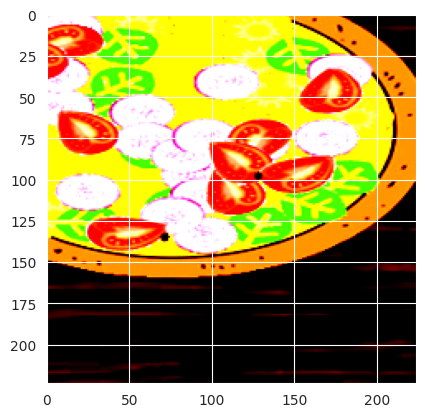

Batch:  1
Predicted labels by the model: basil, olives, pineapple, tomatoes
True labels:  broccoli, pepperoni, tomatoes
Image: 


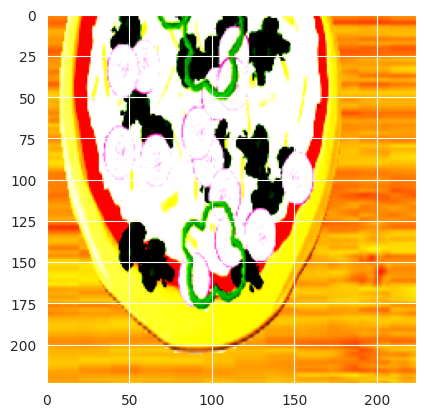

Batch:  2
Predicted labels by the model: bacon, basil, olives, onions, pineapple, tomatoes
True labels:  onions, peppers, pineapple
Image: 


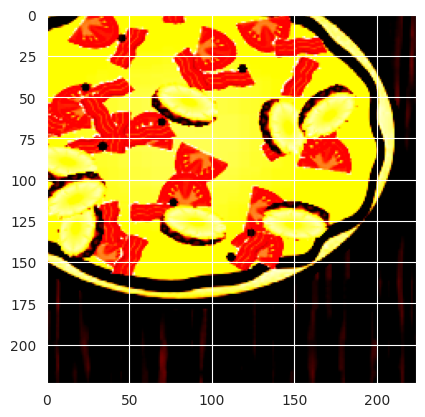

Batch:  3
Predicted labels by the model: basil, broccoli, mushrooms, onions, pepperoni, tomatoes
True labels:  bacon, pepperoni, pineapple
Image: 


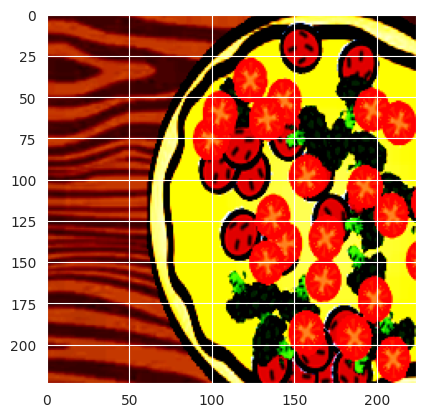

Batch:  4
Predicted labels by the model: basil, broccoli, olives, pepperoni, peppers, pineapple
True labels:  bacon, olives, peppers
Image: 


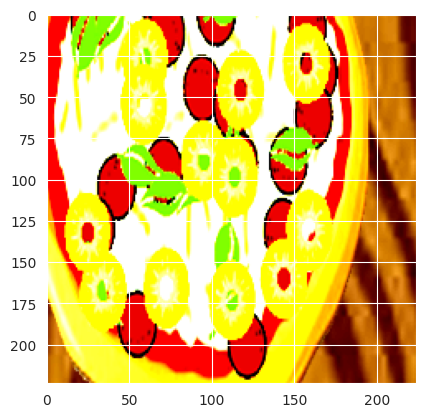

Batch:  5
Predicted labels by the model: broccoli, mushrooms, pepperoni
True labels:  basil
Image: 


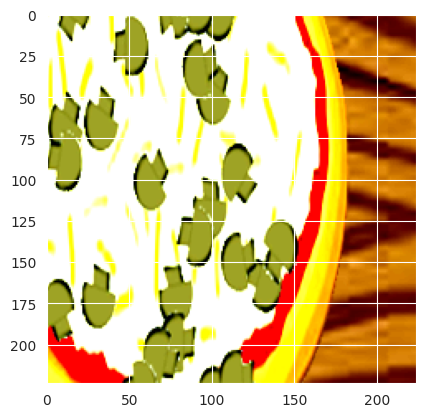

Batch:  6
Predicted labels by the model: broccoli, olives, pineapple, tomatoes
True labels:  onions, peppers, tomatoes
Image: 


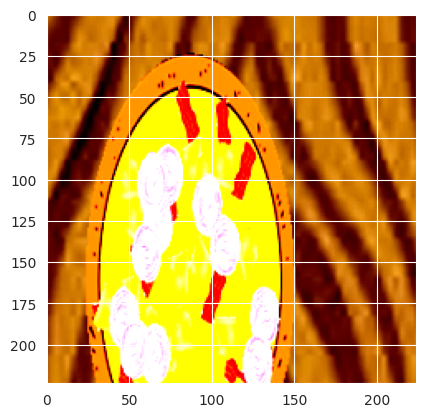

Batch:  7
Predicted labels by the model: basil, olives, onions, pepperoni, pineapple, tomatoes
True labels:  peppers, pineapple
Image: 


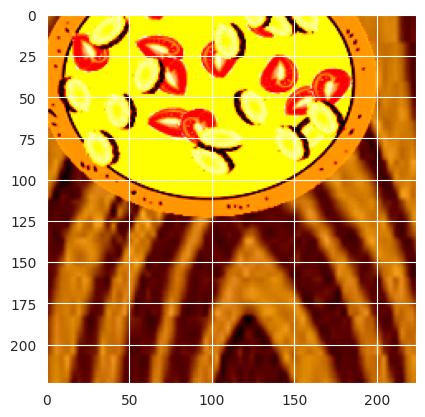

Batch:  8
Predicted labels by the model: olives, pepperoni, peppers
True labels:  broccoli, onions, pepperoni
Image: 


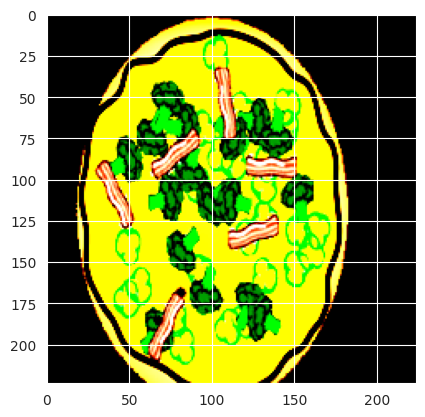

Batch:  9
Predicted labels by the model: basil, mushrooms, pepperoni, pineapple, tomatoes
True labels:  basil, broccoli, olives, pineapple, tomatoes
Image: 


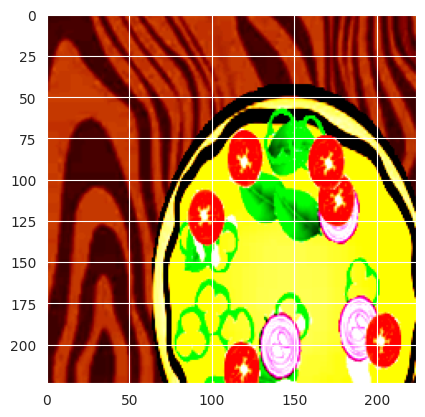

Batch:  10
Predicted labels by the model: bacon, mushrooms, olives, onions, pineapple
True labels:  bacon, onions, tomatoes
Image: 


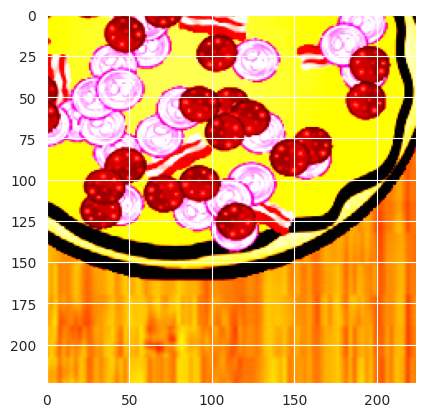

Batch:  11
Predicted labels by the model: basil, mushrooms, pepperoni, peppers
True labels:  mushrooms
Image: 


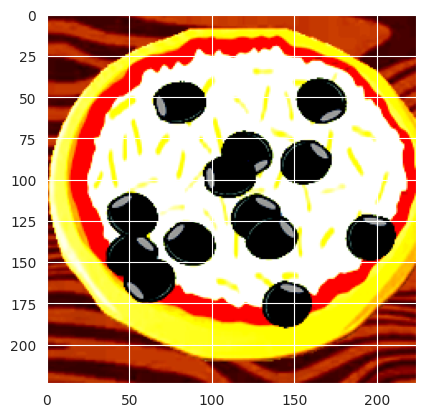

Batch:  12
Predicted labels by the model: basil, broccoli, olives, tomatoes
True labels:  bacon, basil, broccoli, olives, onions, tomatoes
Image: 


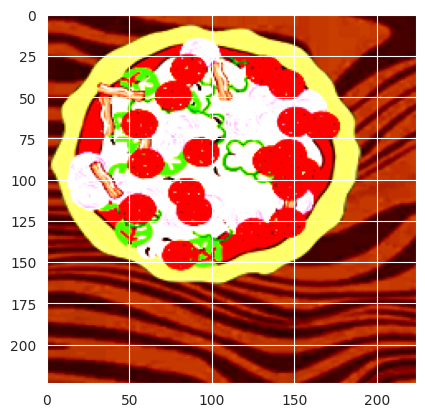

Batch:  13
Predicted labels by the model: basil, broccoli, mushrooms, olives
True labels:  mushrooms, pepperoni, peppers
Image: 


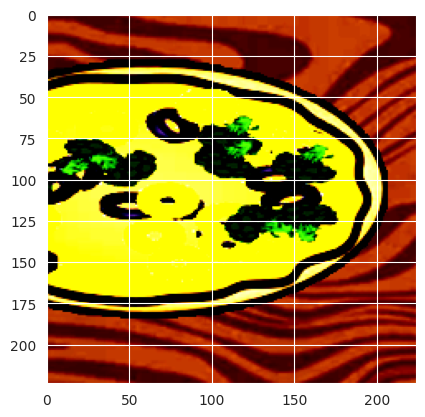

Batch:  14
Predicted labels by the model: basil, broccoli, pepperoni, peppers
True labels:  basil, mushrooms
Image: 


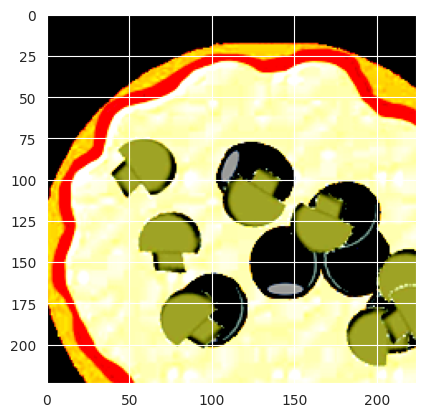

Batch:  15
Predicted labels by the model: basil, broccoli, mushrooms, pepperoni, peppers, pineapple
True labels:  basil, pineapple, tomatoes
Image: 


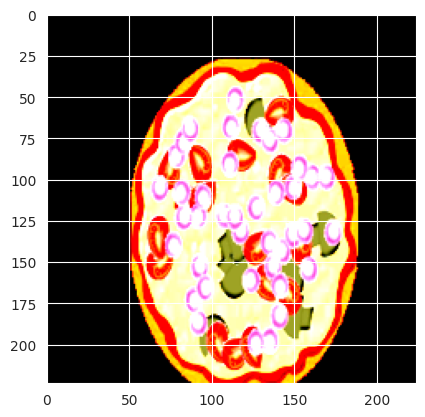

Batch:  16
Predicted labels by the model: basil, broccoli
True labels:  bacon, olives, tomatoes
Image: 


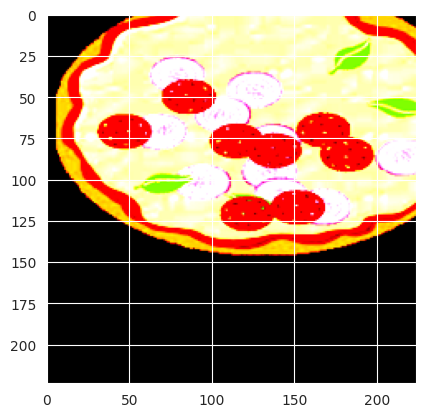

Batch:  17
Predicted labels by the model: basil, broccoli, mushrooms, pepperoni, peppers, pineapple
True labels:  olives, pepperoni, pineapple
Image: 


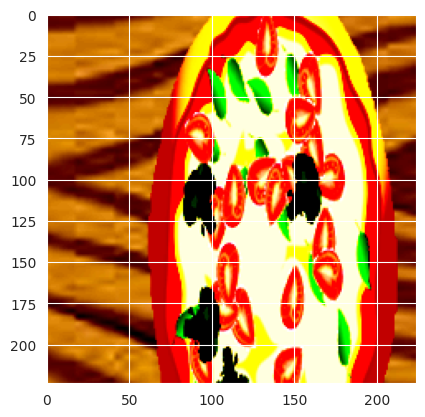

Batch:  18
Predicted labels by the model: olives, pepperoni, pineapple
True labels:  olives, onions, pepperoni, peppers
Image: 


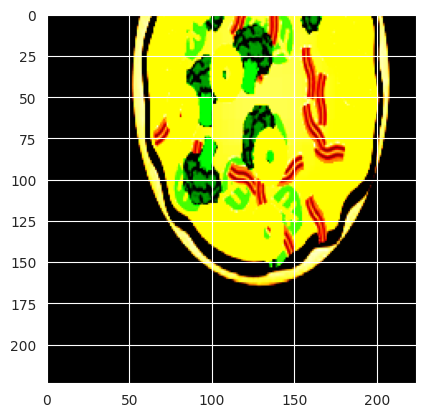

Batch:  19
Predicted labels by the model: basil, mushrooms, olives, onions, peppers
True labels:  basil, tomatoes
Image: 


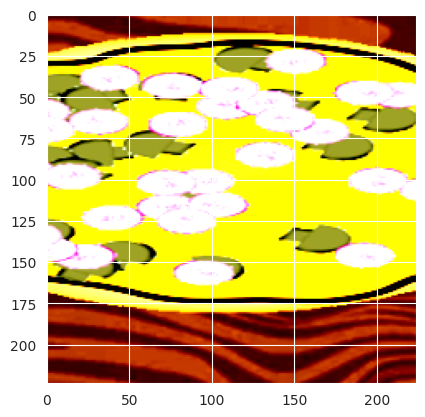

Batch:  20
Predicted labels by the model: basil, mushrooms, onions, peppers, pineapple
True labels:  broccoli, pepperoni, tomatoes
Image: 


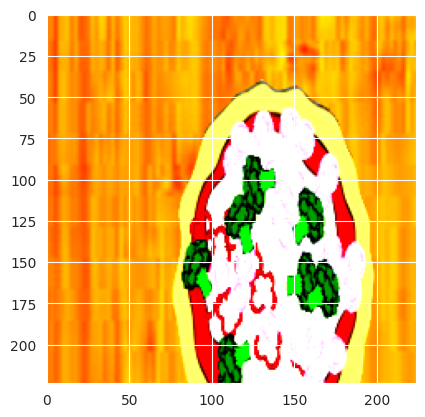

Batch:  21
Predicted labels by the model: basil, broccoli, onions, pineapple, tomatoes
True labels:  mushrooms, onions
Image: 


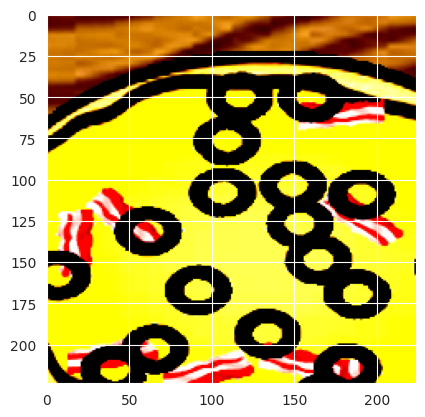

Batch:  22
Predicted labels by the model: basil, broccoli, mushrooms, tomatoes
True labels:  basil, broccoli, peppers, pineapple, tomatoes
Image: 


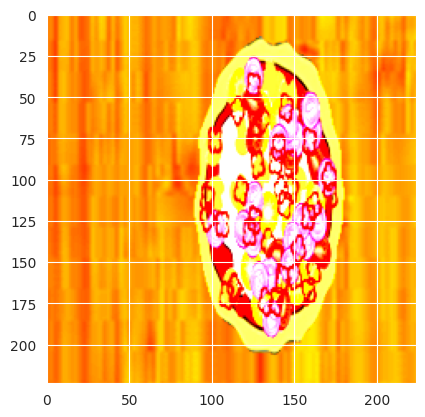

Batch:  23
Predicted labels by the model: bacon, onions, pepperoni, pineapple, tomatoes
True labels:  bacon, broccoli, onions
Image: 


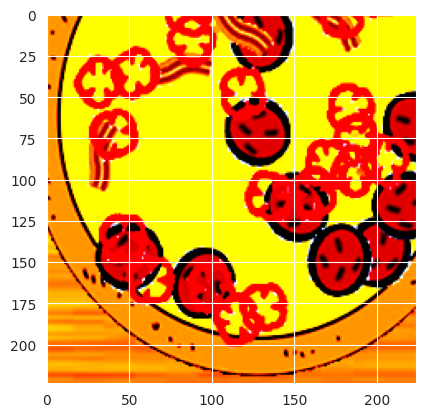

Batch:  24
Predicted labels by the model: basil, broccoli, pepperoni
True labels:  broccoli, olives
Image: 


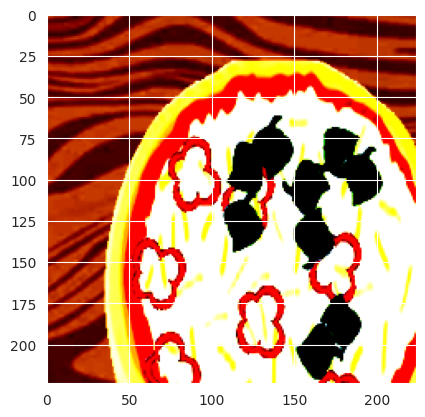

In [89]:
test_random_batch(network=network, labels_name=topping_names, test_dataloader=test_dataloader, device=device)

In [91]:
performance, metrics_report = evaluate_model(network = network, dataloader=test_dataloader, device=device)
print_performance(performance, topping_names)
print("\nMetrics Report: \n", metrics_report)

100%|███████████████████████████████████████████| 20/20 [00:06<00:00,  3.29it/s]



Performance:
Mean accuracy: 52.17%
Accuracy per label:
bacon: 55.53%
basil: 52.31%
broccoli: 48.29%
mushrooms: 54.93%
olives: 49.30%
onions: 54.53%
pepperoni: 53.32%
peppers: 57.55%
pineapple: 44.47%
tomatoes: 51.51%

Metrics Report: 
               precision    recall  f1-score   support

           0       0.27      0.35      0.30       137
           1       0.32      0.57      0.41       146
           2       0.27      0.40      0.32       152
           3       0.33      0.54      0.41       146
           4       0.28      0.48      0.35       145
           5       0.34      0.43      0.38       162
           6       0.36      0.50      0.42       169
           7       0.36      0.51      0.42       149
           8       0.29      0.46      0.36       164
           9       0.36      0.55      0.44       168

   micro avg       0.32      0.48      0.38      1538
   macro avg       0.32      0.48      0.38      1538
weighted avg       0.32      0.48      0.38      1538
 samp

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Feature Extraction

### Compute deep features for images

Helper functions

In [92]:
def extract_feat(model, dataloader):
    feat = []
    for i, data in enumerate(tqdm(dataloader)):
        img, targets = data
        if device.type == 'cuda':
            img, targets = img.cuda(), targets.cuda()
        with torch.no_grad():
            outputs = model(img)
        if device.type == 'cuda':
            feat.append(outputs.cpu().numpy().squeeze())
        else:
            feat.append(outputs.numpy().squeeze())
    return feat


def compute_feat(transform, feat_data_path):
  # Define dataset and dataloader for feat (no transformation)
  all_set_raw_feat = myDataset(x_all, y_all, img_path=train_data_path, img_data=img_all, transform=transform)
  all_dataloader_feat = DataLoader(all_set_raw_feat, batch_size=200, shuffle=False, **kwargs)
  feat = extract_feat(model, all_dataloader_feat)

  # Convert to numpy arrays
  feat = np.array(np.concatenate(feat))

  # Save the features
  print("Storing image features in {}...".format(feat_data_path))
  np.savez_compressed(feat_data_path, img_feat=feat)
  print("Done!")

  return feat

In [93]:
from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights
from torch.utils.data import DataLoader

resnext = torchvision.models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT, progress=True)

if device.type == 'cuda':
    resnext = resnext.cuda()

model = resnext

# Removes the last classification layer
modules=list(model.children())[:-1]
model=nn.Sequential(*modules)
for p in model.parameters():
    p.requires_grad = False


feat1_data_path=os.path.join(DATA_DIR, 'syntheticDataset/train/img_all_feat1_resnext.npz')
feat2_data_path=os.path.join(DATA_DIR, 'syntheticDataset/train/img_all_feat2_resnext.npz')

feat1 = []
feat2 = []

# Checks if feature already exist
if os.path.exists(feat1_data_path):
  print("Loading images with feature 1 from {}".format(feat1_data_path))
  feat1 = np.load(feat1_data_path)
  feat1 = feat1['img_feat']

# Doesn't exists => compute
else:
  print("Computing image feature 1")
  feat1 = compute_feat(val_transform, feat1_data_path)


# Checks if feature already exist
if os.path.exists(feat2_data_path):
  print("Loading images with feature 2 from {}".format(feat2_data_path))
  feat2 = np.load(feat2_data_path)
  feat2 = feat2['img_feat']

# Doesn't exists => compute
else:
  print("Computing image feature 2")
  feat2 = compute_feat(train_transform, feat2_data_path)


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 268MB/s]


Loading images with feature 1 from /content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/img_all_feat1_resnext.npz
Loading images with feature 2 from /content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/img_all_feat2_resnext.npz


In [94]:
# Concatenate feat1 and feat2
X = np.concatenate((feat1, feat2), axis = 0)
y = np.concatenate((y_all, y_all), axis = 0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Random Forest

In [99]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Create a base classifier
base_classifier = RandomForestClassifier(random_state=42)

# Create MultiOutputClassifier
multi_output_classifier = MultiOutputClassifier(base_classifier)

# Train the classifier
multi_output_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = multi_output_classifier.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred, zero_division=1)

# The results
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_str)

Accuracy: 0.08
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.20      0.33       577
           1       0.84      0.10      0.17       603
           2       0.82      0.06      0.11       604
           3       0.93      0.51      0.66       585
           4       0.70      0.09      0.16       601
           5       0.88      0.11      0.19       593
           6       0.92      0.43      0.58       641
           7       0.94      0.16      0.27       582
           8       0.84      0.23      0.36       604
           9       0.95      0.43      0.59       604

   micro avg       0.90      0.23      0.37      5994
   macro avg       0.87      0.23      0.34      5994
weighted avg       0.87      0.23      0.34      5994
 samples avg       0.95      0.27      0.34      5994



Confusion Matrix

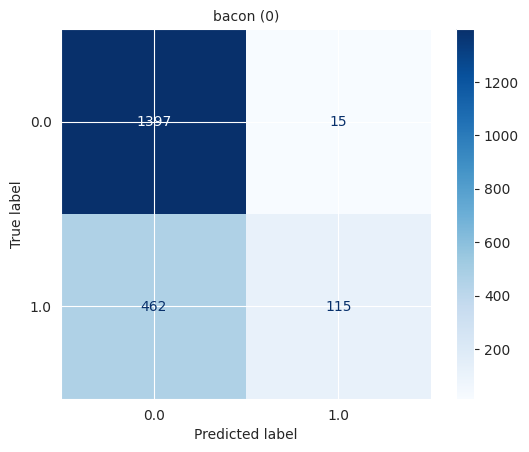

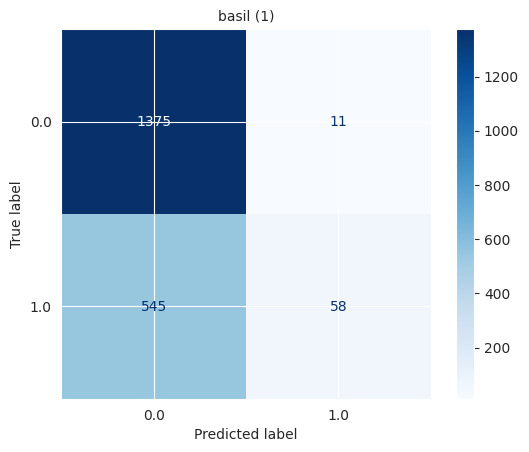

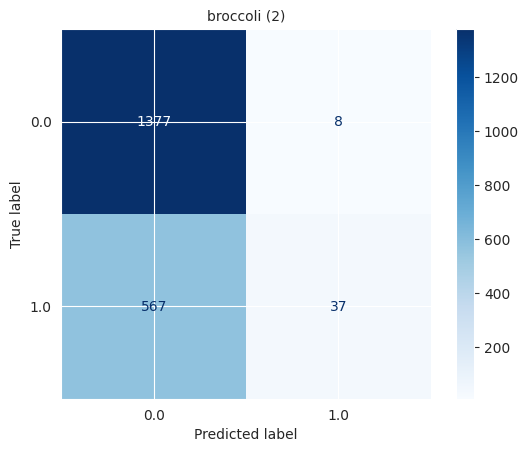

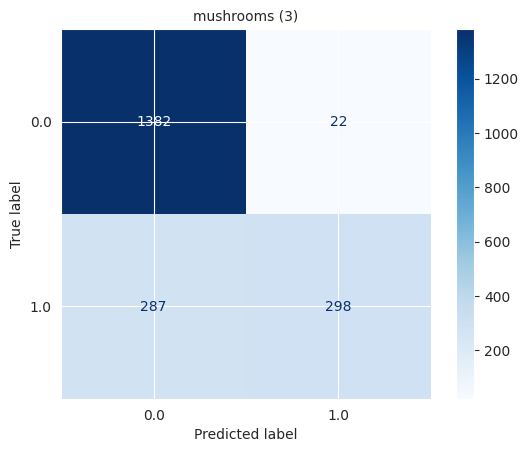

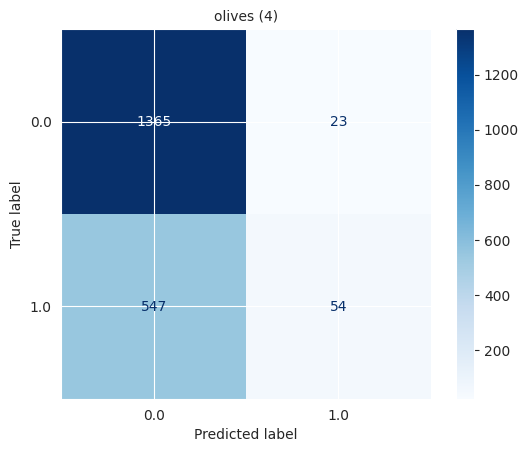

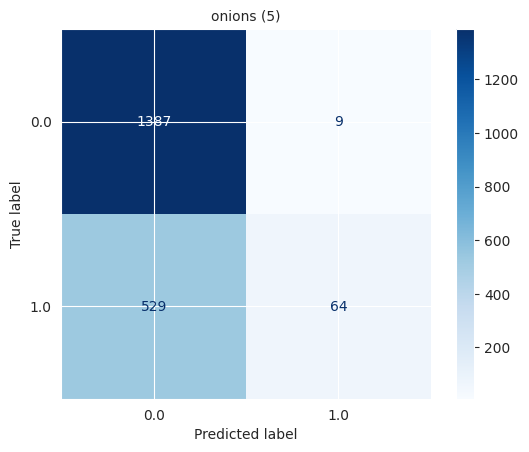

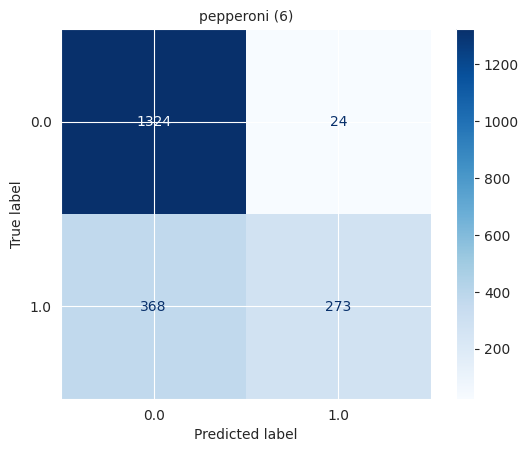

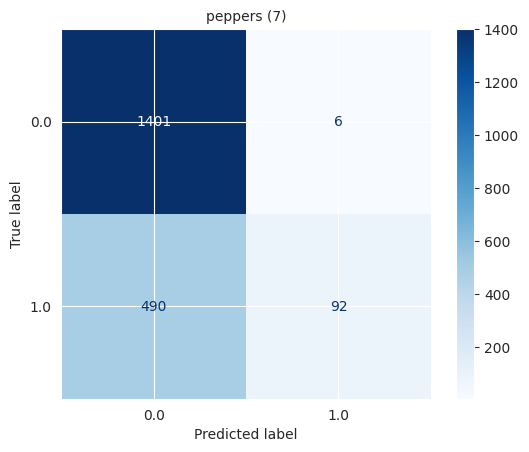

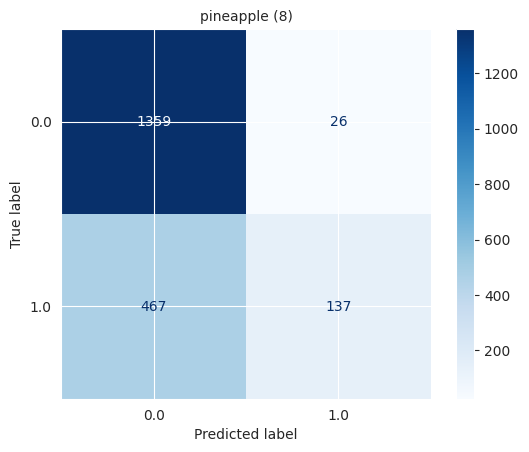

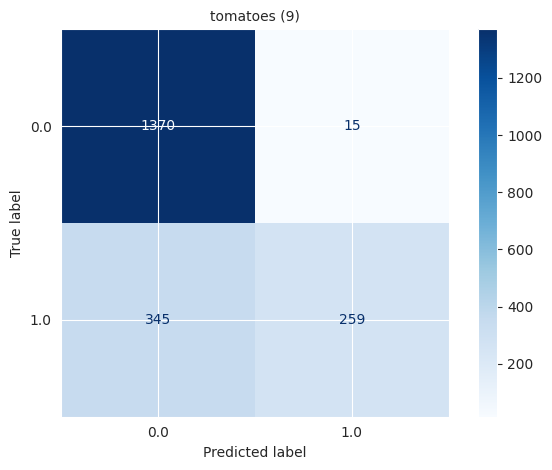

In [100]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

# Get multilabel confusion matrices
matrices = multilabel_confusion_matrix(y_test, y_pred)
classes = [f'{topping} ({index})' for index, topping in enumerate(topping_names)]

# Plot confusion matrix displays for each label
for i in range(len(topping_names)):
    cmd = ConfusionMatrixDisplay(matrices[i], display_labels=np.unique(y_val))
    cmd.plot(cmap='Blues')  # Use 'Blues' colormap
    plt.title(classes[i], fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

## Perceptron

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create a base classifier
base_classifier = Perceptron(random_state=42)

# Create MultiOutputClassifier
multi_output_classifier = MultiOutputClassifier(base_classifier)

# Train the classifier
multi_output_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = multi_output_classifier.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred, zero_division=1)

# The results
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_str)


Accuracy: 0.22
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.69      0.74       571
           1       0.61      0.65      0.63       611
           2       0.74      0.58      0.65       582
           3       0.87      0.90      0.88       592
           4       0.63      0.57      0.60       615
           5       0.75      0.74      0.75       590
           6       0.78      0.76      0.77       595
           7       0.64      0.76      0.70       623
           8       0.75      0.71      0.73       594
           9       0.80      0.87      0.83       645

   micro avg       0.73      0.72      0.73      6018
   macro avg       0.74      0.72      0.73      6018
weighted avg       0.74      0.72      0.73      6018
 samples avg       0.77      0.76      0.72      6018



Plotting the accuracy for each class

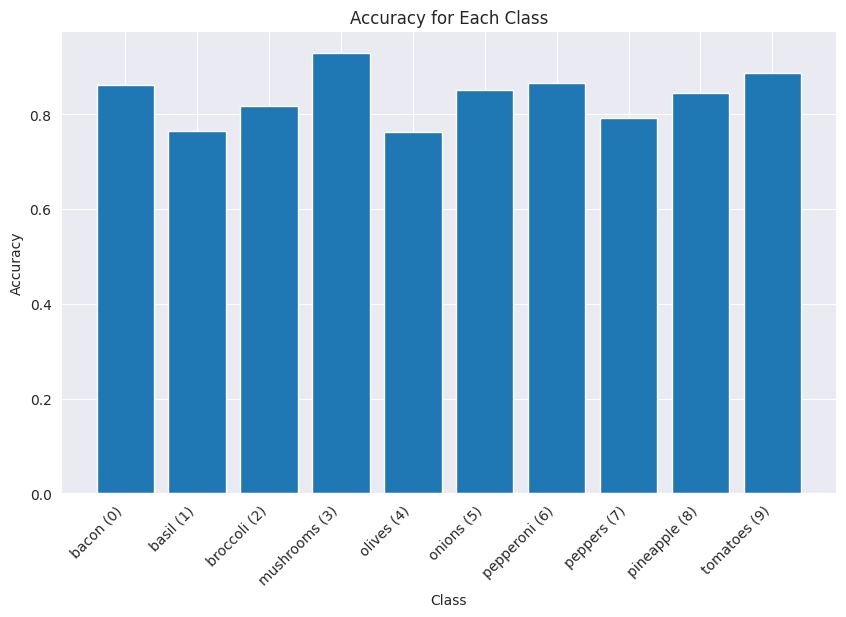

In [ ]:
class_accuracy = np.mean(y_test == y_pred, axis=0)
classes = [f'{topping} ({index})' for index, topping in enumerate(topping_names)]
plt.figure(figsize=(10, 6))
plt.bar(classes, class_accuracy)
plt.title('Accuracy for Each Class')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(classes, rotation=45, ha="right")
plt.xticks(classes)
plt.show()